In [1]:
#final version
import numpy as np # scientific computing 
import scipy.io
from scipy import stats 
import pandas as pd # data manipulation 
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import svm 
import brainiak.funcalign.srm
import brainiak.funcalign.rsrm
from brainiak import image, io
import matplotlib.pyplot as plt
%matplotlib inline 
import time

# useful variables
nScenes = 50
nScenes1 = 27
nTRs1 = 946 
nScenes2 = 23
nTRs2 = 1030
n = 17

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# for each participant (of 17), let's get the recall data for each of 50 scenes
# recalled (1/0), quality (0 if not recalled, else 1-5, 5), recall time len
recall_dfs = []
recall_path = "SherlockData/recall_transcripts/"
for pid in range(1, 18):
    filename = "NN_S" + str(pid) + "_Scene_Matches_edit4matlab.xlsx"
    file = pd.read_excel(recall_path + filename)
    file = file.replace(np.nan, -1, regex=True)
    quality = []
    recalled = []
    duration = []
    for s in range(50):
        if file['quality'][s] == -1: # did not recall
            quality.append(0)
            recalled.append(0)
            duration.append(0)
        else:
            quality.append(file['quality'][s])
            recalled.append(1)
            duration.append(file['end time sec'][s] - file['start time sec'][s])
    recall_dfs.append(np.transpose([recalled, quality, duration]))
recall_dfs = np.array(recall_dfs)

# Load in the brain data: 17 participants, 26k WB mask voxels, 1976 TRs
movie_data = []
for pid in range(1, 18):
    moviedat = np.load("SherlockData/movie_masked/movie_wb_S" + str(pid) + ".npz")['data']
    # stored as TR x voxel, but we want voxel x TR data 
    movie_data.append(np.transpose(moviedat))
movie_data = np.array(movie_data)

movieTRs = np.array(pd.read_csv("movieTRs.csv", index_col = 0))

# zscores a list of 2D arrays, by row
def zscore(data):
    for pid in range(len(data)):
        data[pid] = np.nan_to_num(stats.zscore(data[pid], axis = 1, ddof = 1))
    return np.array(data)

movie_data1 = zscore(movie_data[:, :, :nTRs1])
movie_data2 = zscore(movie_data[:, :, nTRs1:])

# Loading in data describing movie features 
features = pd.read_csv("features.csv", index_col = 0) 

# Given a feature name (string), returns nTRs-len vector of features
def expandFeature(feat):
    ret = []
    curScene = 0
    for i in range(movie_data.shape[2]): # for each TR 
        if (features.fillna(946)).loc[curScene, 'end_TR'] <= i:
            curScene = curScene + 1
        ret.append(features.loc[curScene, feat])
    return np.array(ret)

# Downsampling function:
# given data matrix of 1 participant (features x TRs), start and end scenes
# returns a features x SCENEs matrix, where 
# corresponding TRs in a scene are averaged 
# run2 = if the dat_tr is from the second run
def scene_voxelavg(dat_tr, startind, endind = nScenes, run2 = True):
    dat_sc = []
    for sceneidx in range(startind, endind):
        startTR = movieTRs[sceneidx, 1] - 1 
        endTR = movieTRs[sceneidx, 2] - 1 
        if run2:
            startTR = startTR - nTRs1
            endTR = endTR - nTRs1
        response_avg = np.reshape(np.mean(dat_tr[:,startTR:endTR + 1], axis = 1), (-1, 1))
        if len(dat_sc) == 0:
            dat_sc = response_avg
        else:
            dat_sc = np.append(dat_sc, response_avg, axis = 1)
    return np.array(dat_sc)

# given a participant index and
# recalltype (0 for nRecall, 1 for time of recall, 2 for quality of recall)
# returns a nTRs-len vector representation for recall from start scene index
def get_recall_labels(pidx, startind, recalltype, endind = nScenes):
    labels_byTR = []
    startTR = movieTRs[startind, 1] - 1 
    for sceneidx in range(startind, endind):
        endTR = movieTRs[sceneidx, 2] - 1 
        labels_byTR = np.append(labels_byTR, 
            np.repeat(recall_dfs[pidx, sceneidx, recalltype], endTR-startTR+1))
        startTR = endTR + 1
    return labels_byTR

# takes a list of l (v, t) brain data matrices and flattens them 
# such that they are concatenated by TR's, then transposes
# new dimensions = t * l, v
def flatdat(dat):
    dat = zscore(dat) # in case not already done
    flat = dat[0]
    for i in range(1, len(dat)):
        flat = np.append(flat, dat[i], axis = 1)
    return np.array(flat.T)

def flatlabs(labels):
    flat = labels[0]
    for i in range(1, len(labels)):
        flat = np.append(flat, labels[i])
    return np.array(flat)

def predict(traindat, labels, testdat, classifier):
    # Flatten the data and labels; fitting classifier 
    classifier.fit(flatdat(traindat), labels)
    # Making predictions
    return classifier.predict(flatdat(testdat))

# Predicts the variable for one participant, training on the others 
# note: run is the half of the movie we are PREDICTING on 
def predictVarLOO(varvec, pid, run, classifier = svm.SVC()):
    train_pids = [i for i in range(n) if i != pid]
    test_pids = [pid]

    # Learning subject specific bases 
    srm = brainiak.funcalign.srm.SRM(n_iter = 10, features = 50)
    if run == 1:
        srm_data = movie_data2
        model_data = movie_data1
    else:
        srm_data = movie_data1
        model_data = movie_data2
    
    srm.fit(srm_data[train_pids])
    w_test = [srm.transform_subject(srm_data[i]) for i in test_pids]

    test_data = []
    for i in range(len(test_pids)):
        test_data.append(np.matmul(w_test[i].T, model_data[test_pids[i]]))

    train_data = zscore(srm.transform(model_data[train_pids]))
    test_data = zscore(test_data)

    train_size = len(train_pids)
    trainlabels = np.array([varvec for i in range(train_size)]).flatten()
    testlabels = np.array([varvec for i in range(n - train_size)]).flatten()

    return np.reshape(np.array(predict(train_data, trainlabels, test_data, classifier)), (1, -1))

def predictVarLOOCV(var, x, run = 2, classifier = svm.SVC()):
    cvscores = []
    if run == 1:
        varvec = expandFeature(var)[:nTRs1]
    else:
        varvec = expandFeature(var)[nTRs1:]
    for pid in range(n): # leave one participant out for the cv 
        predictVarLOO(varvec, pid, run, classifier)
        cvscores.append([np.mean(preds == varvec), 
                         np.corrcoef(preds, varvec)])
    return np.array(cvscores) # list of accuracy and correlation coefficients for each subject

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [3]:
# We'll work with feature matrices for predictions of run 2

featmats = []
for pid in range(n):
    featmats.append(np.load("FeaturePredictions/featmat" + str(pid) + ".npz")["data"])
featmats = np.array(featmats)

np.shape(featmats)

(17, 14, 1030)

In [5]:
#def predictVarLOO(varvec, pid, run, classifier = svm.SVC()):
def predictNullLOO(var, pid, run = 2, classifier = svm.SVC()):
    if run == 1:
        varvec = expandFeature(var)[:nTRs1]
    else:
        varvec = expandFeature(var)[nTRs1:]
    nullvec = np.random.choice(varvec, size = len(varvec), replace = False)
    return predictVarLOO(nullvec, pid, run, classifier)
        

In [6]:
def getnullfeats(pid, run):
    nullmat = predictNullLOO(features.columns[2], pid, run, svm.SVR())
    for feat in features.columns[3:6]:
        featvec = predictNullLOO(feat, pid, run, svm.SVR())
        nullmat = np.append(nullmat, featvec, axis = 0)
    for feat in features.columns[6:]:
        print(feat, "Feature matrix current shape: ", np.shape(nullmat))
        featvec = predictNullLOO(feat, pid, run, svm.SVC())
        nullmat = np.append(nullmat, featvec, axis = 0)
    if run == 1:
        return np.reshape(np.array(nullmat), (-1, nTRs1))
    return np.reshape(np.array(nullmat), (-1, nTRs2))

In [ ]:
for pid in range(12, n):
    start = time.time()
    nullmat = getnullfeats(pid, 2)
    np.savez("FeaturePredictions/nullmat" + str(pid) + ".npz", data = nullmat)
    print("pid done", time.time() - start)

text Feature matrix current shape:  (4, 1030)
speech Feature matrix current shape:  (5, 1030)
music Feature matrix current shape:  (6, 1030)
outdoors Feature matrix current shape:  (7, 1030)
new_scene Feature matrix current shape:  (8, 1030)
char_infocus Feature matrix current shape:  (9, 1030)
char_present Feature matrix current shape:  (10, 1030)
mainchar_infocus Feature matrix current shape:  (11, 1030)
mainchar_present Feature matrix current shape:  (12, 1030)
mainchar_speaking Feature matrix current shape:  (13, 1030)
pid done 1250.979570865631
text Feature matrix current shape:  (4, 1030)
speech Feature matrix current shape:  (5, 1030)
music Feature matrix current shape:  (6, 1030)
outdoors Feature matrix current shape:  (7, 1030)
new_scene Feature matrix current shape:  (8, 1030)
char_infocus Feature matrix current shape:  (9, 1030)
char_present Feature matrix current shape:  (10, 1030)
mainchar_infocus Feature matrix current shape:  (11, 1030)
mainchar_present Feature matrix cu

In [4]:
predresults = []
nullresults = []
for pid in range(n):
    nullmat = np.load("FeaturePredictions/nullmat" + str(pid) + ".npz")["data"]
    for featnum in range(14):
        #plt.figure()
        feat = features.columns[featnum + 2]
        featvec = expandFeature(feat)[nTRs1:]
        #plt.scatter(range(nTRs2), featvec)
        #plt.scatter(range(nTRs2), featmats[pid, featnum, :])
        #plt.scatter(range(nTRs2), nullmat[featnum, :])
        #plt.legend(["Feature", "Prediction", "Null"])
        if (featnum < 4):
            predcorr = np.round(np.corrcoef(featmats[pid, featnum, :], featvec)[0, 1], 3)
            nullcorr = np.round(np.corrcoef(nullmat[featnum, :], featvec)[0, 1], 3)
            #plt.title(feat + ": " + str(predcorr) + " " + str(nullcorr))
            predresults.append(predcorr)
            nullresults.append(nullcorr)
        else:
            prederr = np.round(np.mean(featmats[pid, featnum, :] == featvec), 3)
            nullerr = np.round(np.mean(nullmat[featnum, :] == featvec), 3)
            #plt.title(feat + ": " + str(prederr) + " " + str(nullerr))
            predresults.append(prederr)
            nullresults.append(nullerr)

In [5]:
predresults = np.array(np.reshape(predresults, [n, 14]))
nullresults = np.array(np.reshape(nullresults, [n, 14]))

arousal_mean 0.0003
arousal_std 0.0003
valence_mean 0.0003
valence_std 0.0003
text 0.0003
speech 0.0003
music 0.0004
outdoors 0.0005
new_scene 0.009
char_infocus 0.0056
char_present 0.0045
mainchar_infocus 0.0003
mainchar_present 0.0004
mainchar_speaking 0.0003


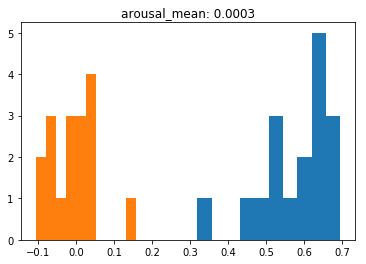

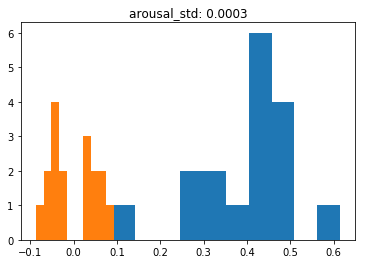

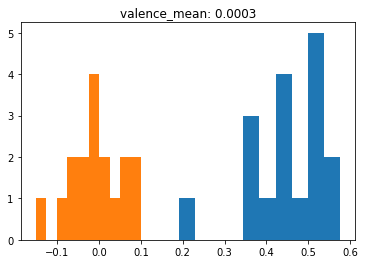

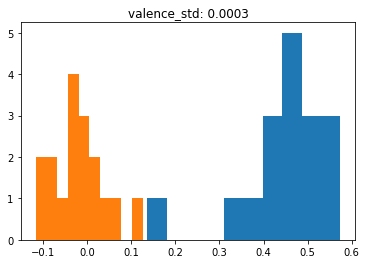

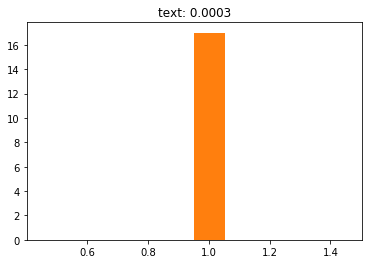

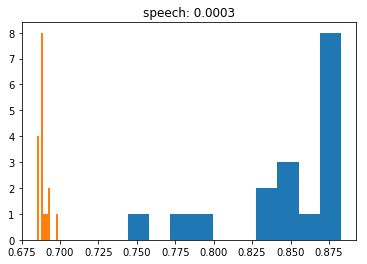

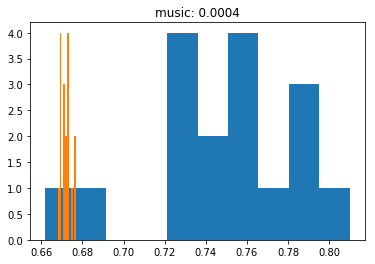

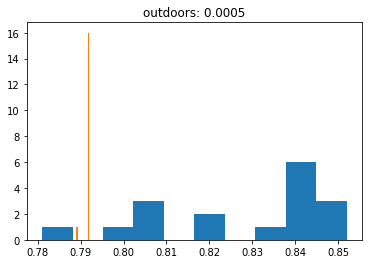

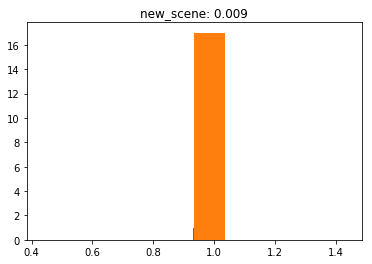

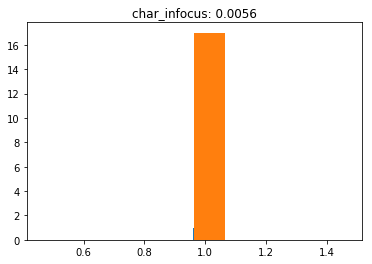

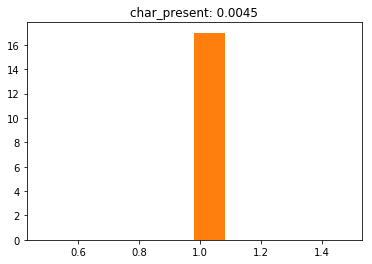

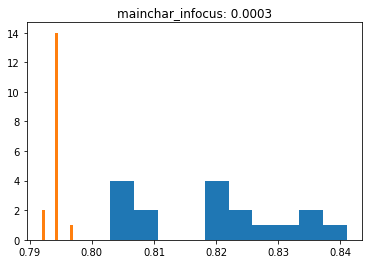

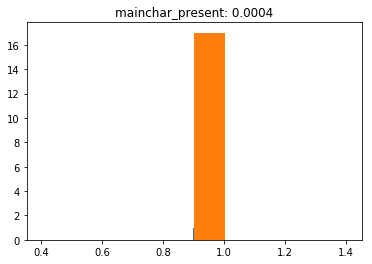

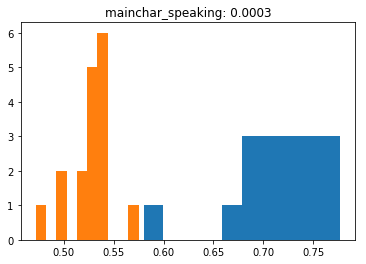

In [47]:
featsigs = []
for feat in range(14):
    featsigs.append(round(stats.wilcoxon(predresults[:, feat], nullresults[:, feat])[1], 4))
    print(features.columns[feat + 2], featsigs[feat])
    plt.figure()
    plt.hist(predresults[:, feat])
    plt.hist(nullresults[:, feat])
    plt.title(features.columns[feat + 2] + ": " + str(featsigs[feat]))

In [44]:
# even though some violate normality assumptions, let's try and see what happens when we use a paired t-test
pairedtest = []
for feat in range(14):
    pairedtest.append(round(stats.ttest_rel(predresults[:, feat], nullresults[:, feat])[1], 4))
    print(features.columns[feat + 2], pairedtest[feat])

arousal_mean 0.0
arousal_std 0.0
valence_mean 0.0
valence_std 0.0
text 0.0
speech 0.0
music 0.0
outdoors 0.0
new_scene 0.0083
char_infocus 0.0024
char_present 0.0009
mainchar_infocus 0.0
mainchar_present 0.0
mainchar_speaking 0.0


In [30]:
# independent
# even though some violate normality assumptions, let's try and see what happens when we use a paired t-test
indtest = []
for feat in range(14):
    indtest.append(round(stats.ttest_ind(predresults[:, feat], nullresults[:, feat])[1], 4))
    print(features.columns[feat + 2], indtest[feat])

arousal_mean 0.0
arousal_std 0.0
valence_mean 0.0
valence_std 0.0
text 0.0
speech 0.0
music 0.0
outdoors 0.0
new_scene 0.005
char_infocus 0.0011
char_present 0.0003
mainchar_infocus 0.0
mainchar_present 0.0
mainchar_speaking 0.0
